### Assignment 3 by Agajan Torayev (matr.: 3067341)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import itertools
import time
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Setup

In [2]:
# transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


# split train set in 0.8/0.2 train/validation sets
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size

trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

input_dim = 3 * 32 * 32
output_dim = 10

print("Train set size: {}, Valid set size: {}, Test set size: {}".format(
        len(trainset), len(validset), len(testset)
        ))

Files already downloaded and verified
Files already downloaded and verified
Train set size: 40000, Valid set size: 10000, Test set size: 10000


### Define functions

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Credits: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def train(model, trainset, optimizer, **params):
    """Trains model on a given trainset."""
    model.train()
    
    # create trainloader and testloader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'],
                                      shuffle=True, num_workers=2)
    
    total_iters = 0
    losses = []
    for epoch in range(params['epochs']):
        
        loss_sum = 0.0
        num_iters = 0
        
        for data in trainloader:
            
            # prepare inputs
            images, labels = data
            images, labels = images.to(params['device']), labels.to(params['device'])
            inputs = images.view(-1, model.input_dim)
            
            # forward
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            
            # add regularization, only for weights not for biases
            regW = 0
            for p in model.named_parameters():
                if p[0].endswith('weight'):
                    regW += torch.sum(p[1]**2)
            loss += params['reg_strength'] * regW
            
            # backward
            loss.backward()
            optimizer.step()
            
            # record losses
            loss_sum += loss.item()
            num_iters += 1
            
        # print epoch loss
        total_iters += num_iters
        epoch_loss = loss_sum / num_iters
        losses.append(epoch_loss)
        print('Epoch: {}, total iters: {}, loss: {:.3f}'.format(epoch, total_iters, epoch_loss))
        
    # losses per iteration
    return losses

def test(model, testset, batch_size=64):
    """Tests the model on a given testset and returns all true and predicted labels."""
    model.eval()
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    total = len(testset)
    correct = 0
    
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            inputs = images.view(-1, model.input_dim)
            outputs = model(inputs)
            
            probs, pred_labels = torch.max(outputs.data, 1)
            correct += (pred_labels == labels).sum().item()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(pred_labels.cpu().numpy())
    
    all_labels = np.hstack(all_labels)
    all_preds = np.hstack(all_preds)
    
    return (all_labels, all_preds)

def train_and_test(model, optimizer, params, plot_loss=False):
    """Train and test model with given optimizer."""
    
    # train
    print("Training...")
    tic = time.time()
    losses = train(model, trainset, optimizer, **params)
    print("Training time: {:.5f} seconds.".format(time.time()-tic))

    print("Testing...")
    train_labels, train_preds = test(model, trainset)
    valid_labels, valid_preds = test(model, validset)

    train_acc = sklearn.metrics.accuracy_score(train_labels, train_preds) * 100
    valid_acc = sklearn.metrics.accuracy_score(valid_labels, valid_preds) * 100

    print("Train set accuracy: {:.2f}%, Valid. set accuracy: {:.2f}%".format(train_acc, valid_acc))
    
    if plot_loss:
        # plot losses
        plt.title("Loss per Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(losses)
        plt.show()

### Define a Model

In [4]:
class LRModel(nn.Module):
    """Logistic regression model with single hidden layer."""
    
    def __init__(self, input_dim, output_dim, hidden=300, dropout=0.2, activation=F.relu):
        super(LRModel, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        
        self.fc1 = nn.Linear(input_dim, hidden)
        self.a1_dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, output_dim)
    
    def forward(self, x):
        a1 = self.activation(self.fc1(x))
        a1_drop = self.a1_dropout(a1)
        out = self.fc2(a1_drop)
        return F.log_softmax(out, dim=1)

### Train a model with a SGD + momentum

In [11]:
# parameters
params = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'epochs': 5,
    'batch_size': 64,
    'reg_strength': 0.003
}

# model
model = LRModel(input_dim, output_dim, hidden=300, dropout=0.55, activation=F.relu)
# do this before optimizer
model.to(params['device'])

# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.1)

train_and_test(model, optimizer, params)

Training...
Epoch: 0, total iters: 625, loss: 2.140
Epoch: 1, total iters: 1250, loss: 1.958
Epoch: 2, total iters: 1875, loss: 1.885
Epoch: 3, total iters: 2500, loss: 1.839
Epoch: 4, total iters: 3125, loss: 1.809
Training time: 32.54642 seconds.
Testing...
Train set accuracy: 47.56%, Valid. set accuracy: 45.65%


### Statistics for the test set

Test set accuracy: 44.92%
Confusion matrix, without normalization


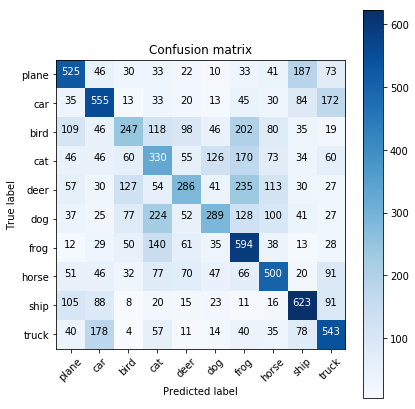

In [6]:
test_labels, test_preds = test(model, testset)
print("Test set accuracy: {:.2f}%".format(sklearn.metrics.accuracy_score(test_labels, test_preds)*100))

# confusion matrix
cm = sklearn.metrics.confusion_matrix(test_labels, test_preds, labels=range(10))
plot_confusion_matrix(cm, classes)

### Different Optimizers

In [7]:
# choose default parameters
optims = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'Adagrad': optim.Adagrad,
    'Adadelta': optim.Adadelta,
    'RMSprop': optim.RMSprop
}

# parameters
params = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'epochs': 2,
    'batch_size': 64,
    'reg_strength': 0.01
}

for optim_name, optimObj in optims.items():

    # new model for every optimizer
    model = LRModel(input_dim, output_dim)
    model.to(params['device']) ## do this before optimizer

    # optimizer
    if optim_name == 'SGD':
        optimizer = optimObj(model.parameters(), lr=1e-2)
    else:
        optimizer = optimObj(model.parameters())
    
    print("Training with optimizer: {}".format(optim_name))
    train_and_test(model, optimizer, params)
    print()
    

Training with optimizer: SGD
Training...
Epoch: 0, total iters: 625, loss: 2.866
Epoch: 1, total iters: 1250, loss: 2.500
Training time: 13.53901 seconds.
Testing...
Train set accuracy: 41.94%, Valid. set accuracy: 41.43%

Training with optimizer: Adam
Training...
Epoch: 0, total iters: 625, loss: 2.103
Epoch: 1, total iters: 1250, loss: 1.991
Training time: 18.29930 seconds.
Testing...
Train set accuracy: 39.36%, Valid. set accuracy: 39.06%

Training with optimizer: Adagrad
Training...
Epoch: 0, total iters: 625, loss: 2.099
Epoch: 1, total iters: 1250, loss: 1.855
Training time: 18.22748 seconds.
Testing...
Train set accuracy: 43.01%, Valid. set accuracy: 41.63%

Training with optimizer: Adadelta
Training...
Epoch: 0, total iters: 625, loss: 2.175
Epoch: 1, total iters: 1250, loss: 2.077
Training time: 20.12206 seconds.
Testing...
Train set accuracy: 34.78%, Valid. set accuracy: 34.40%

Training with optimizer: RMSprop
Training...
Epoch: 0, total iters: 625, loss: 12.030
Epoch: 1, to

### Different activation functions

In [8]:
# parameters
params = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'epochs': 2,
    'batch_size': 64,
    'reg_strength': 0.01
}

activs = {
    'ReLU': F.relu,
    'tanh': torch.tanh,
    'sigmoid': torch.sigmoid
}

for activ in activs:
    # model
    model = LRModel(input_dim, output_dim, hidden=300, dropout=0.2, activation=activs[activ])
    # do this before optimizer
    model.to(device)

    # optimizer
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
    
    print("Training with activation function: {}".format(activ))
    train_and_test(model, optimizer, params)
    print()

Training with activation function: ReLU
Training...
Epoch: 0, total iters: 625, loss: 2.542
Epoch: 1, total iters: 1250, loss: 2.040
Training time: 14.53643 seconds.
Testing...
Train set accuracy: 45.59%, Valid. set accuracy: 44.63%

Training with activation function: tanh
Training...
Epoch: 0, total iters: 625, loss: 2.575
Epoch: 1, total iters: 1250, loss: 2.119
Training time: 15.90985 seconds.
Testing...
Train set accuracy: 40.88%, Valid. set accuracy: 40.12%

Training with activation function: sigmoid
Training...
Epoch: 0, total iters: 625, loss: 2.766
Epoch: 1, total iters: 1250, loss: 2.291
Training time: 14.27122 seconds.
Testing...
Train set accuracy: 33.75%, Valid. set accuracy: 35.11%



### Softmax Loss and SVM Loss

In [9]:
def softmax_loss(scores, targets):
    """Computes softmax loss.
    
    Args:
        scores: `torch.tensor` of shape (num_examples, dimension)
        targets: `torch.tensor` of size (num_examples)
    Returns: Cross Entropy Loss
    """
    N = scores.shape[0]
    exp_scores = torch.exp(scores)
    probs = exp_scores / torch.sum(exp_scores, 1, keepdim=True)
    log_probs = torch.log(probs)
    
    loss = torch.sum(-log_probs[range(N), targets]) / N
    return loss

def svm_loss(scores, targets, margin=1):
    """Computes SVM loss.
    
    Args:
        scores: `torch.tensor` of shape (num_examples, dimension)
        targets: `torch.tensor` of size (num_examples)
    
    Returns: Cross SVM Loss
    """
    N = scores.shape[0]
    correct_scores = scores[range(N), targets].view(-1, 1)
    margins = torch.clamp(scores - correct_scores + margin, min=0.0)
    margins[range(N), targets] = 0
    loss = torch.sum(margins) / N
    
    return loss
    

# test implementation
scores = torch.randn(4, 6)
targets = torch.tensor([0, 1, 0, 3])

print("Softmax Loss")
print("Custom implementation: {}".format(softmax_loss(scores, targets)))
print("torch.nn implementation: {}".format(F.nll_loss(F.log_softmax(scores, dim=1), targets)))

print("\nSVM Loss, custom implementation: {}".format(svm_loss(scores, targets)))

Softmax Loss
Custom implementation: 3.0683436393737793
torch.nn implementation: 3.0683436393737793

SVM Loss, custom implementation: 9.855130195617676
